In [1]:
import torch
from transformers import *
import random
import numpy as np
import sys

sys.path.append("../../src")
from explainer import Archipelago
from application_utils.text_utils import *
from application_utils.text_utils_torch import BertWrapperTorch
from viz.text import viz_text, _set_axis_config

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import lines

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Get Model

In [2]:
device = torch.device("cuda:0")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_path = "../../downloads/pretrained_bert"
model = BertForSequenceClassification.from_pretrained(model_path)
model_wrapper = BertWrapperTorch(model, device)

## Get Text

In [3]:
ss = get_sst_sentences(split="test", path="../../downloads/sst_data/sst_trees.pickle")
random.seed(42)
random.shuffle(ss)

## Get Explanations

In [4]:
baseline_token = "_"

top_k=3

result_list = []

for t, text in enumerate(ss[:5]):
    
    if t == 1: continue # skip sentence at t=1 because it is too long for the paper

    text_ids, baseline_ids = get_input_baseline_ids(text, baseline_token, tokenizer)
    class_idx = 1
    logit = model_wrapper([text_ids])[0,class_idx].item()
    polarity = "pos" if logit > 0 else "neg"

    xf = TextXformer(text_ids, baseline_ids) 
    apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)

    explanation = apgo.explain(top_k=top_k)
    
    tokens = get_token_list(text_ids, tokenizer)    
    explanation, tokens = process_stop_words(explanation, tokens)        
    result_list.append( {"tokens": tokens, "explanation": explanation, "prediction_sign": polarity})
    
    print(text, "prediction:", polarity)
    print()

I regret to report that these ops are just not extreme enough . prediction: neg

It 's a worse sign when you begin to envy her condition . prediction: neg

It 's solid and affecting and exactly as thought-provoking as it should be . prediction: pos

A lousy movie that 's not merely unwatchable , but also unlistenable . prediction: neg



## Plotting Code

In [5]:
stixfont = {'fontname':'STIXGeneral'}

matplotlib.rcParams['mathtext.fontset'] = 'cm'
    
def plot(result_list, save_file):
    spacing = 0.6
    
    figsize = (30, 2) # TODO auto size this

    fig = plt.figure(figsize=figsize)
    plt.axis('off')

    line_ax = fig.add_axes([0.502, 1, 0.05, 2.4])
    x,y = np.array([[0, 0], [0, 10]])
    line = lines.Line2D(x, y, lw=3., color='grey', alpha=1)
    line_ax.add_line(line)
    _set_axis_config(line_ax, clear_y_ticks=True, clear_x_ticks=True)

    text_ax = fig.add_axes([0.5084, 3.25, 0.1, 0.1])
    text_ax.text(x=0, y =0,  s="$f_{cls}$", fontsize=30, **stixfont, zorder=100)
    _set_axis_config(text_ax, clear_y_ticks=True, clear_x_ticks=True)

    
    for r, res in enumerate(result_list):
        explanation = res["explanation"]
        tokens = res["tokens"]
        pred_sign = res["prediction_sign"]
        
        if r !=3:
            shift = 0.05
        else:
            shift = 0
            
        y_pos = (len(result_list)-r)*spacing + shift
        
        axis_coords = [0,y_pos,0.6,1]
        
        text_ax = fig.add_axes([0.51, y_pos+0.5, 0.1, 0.1])
        text_ax.text(x=0, y =0,  s="" + str(pred_sign) + "", fontsize=26, **stixfont)
        _set_axis_config(text_ax, clear_y_ticks=True, clear_x_ticks=True)

        
        if r == 0:
            cbar_pos = [0.44,y_pos + 0.2, 0.014, 0.6]
        else:
            cbar_pos = None

        axis = fig.add_axes(axis_coords)

        viz_text(
            explanation,
            tokens,
            fig=fig,
            axis=axis,
            
            shift = 0,
            arrow_shift = 0.21,
            fontweight = 500,
            fontsize = 20,
            arrow_base_level = 22,
            arrow_ext_const = 6,
            arrow_head_width = 4,
            arrow_head_length = 8,
            arrow_linewidth = 0.8,
            spacing = 0.017,
            empty_spacing = 0.008,
            show_colorbar=True,
            cbar_pos = cbar_pos,
            cbar_fontsize = 24,
            clearfig=False,
        )

    
    if save_file is not None:
        plt.savefig(save_file, bbox_inches="tight")

## Plot Explanations

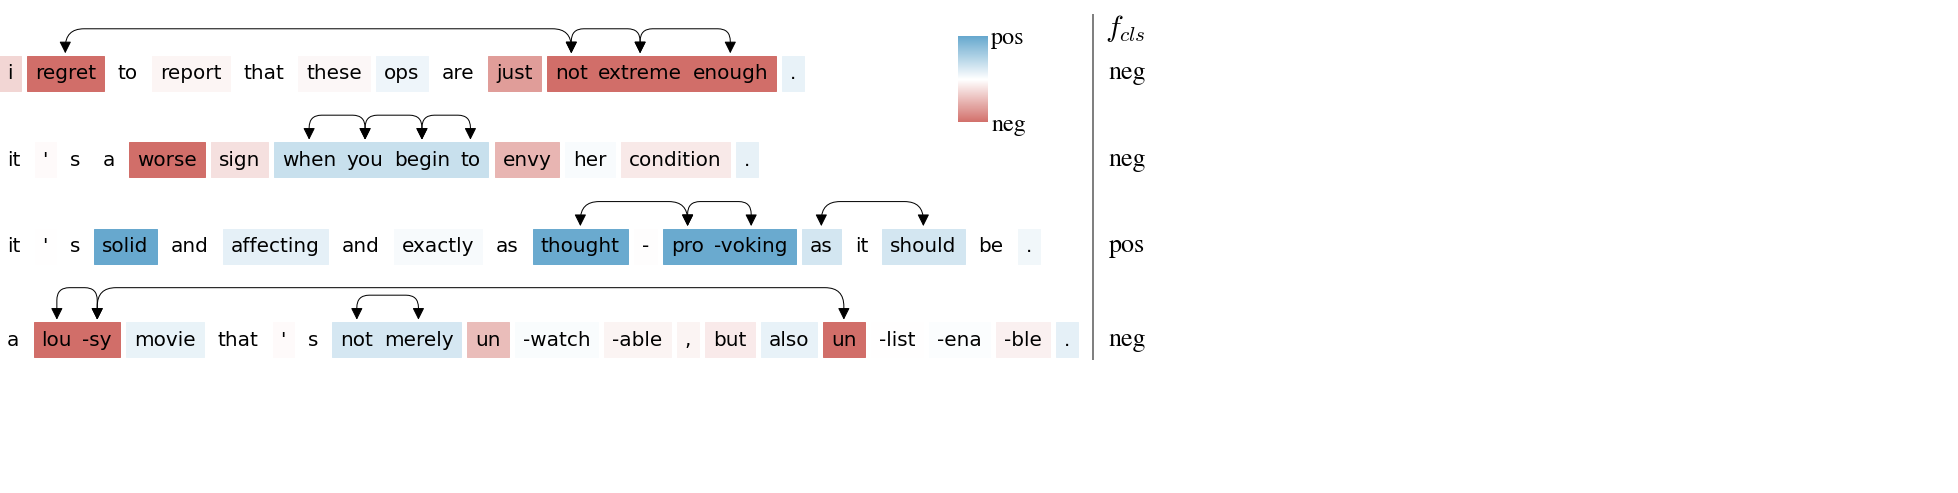

In [6]:
plot(result_list, save_file=None)